# Regression Model Comparison on Housing Dataset

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

Dataset shape: (20640, 10)
Missing values per column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Using 'median_house_value' as target

Results:
            Model         RMSE       R2
    Random Forest 48810.873016 0.818186
    Decision Tree 62812.997150 0.698913
Linear Regression 70059.193339 0.625438
            Lasso 70059.201689 0.625438
            Ridge 70067.481228 0.625350


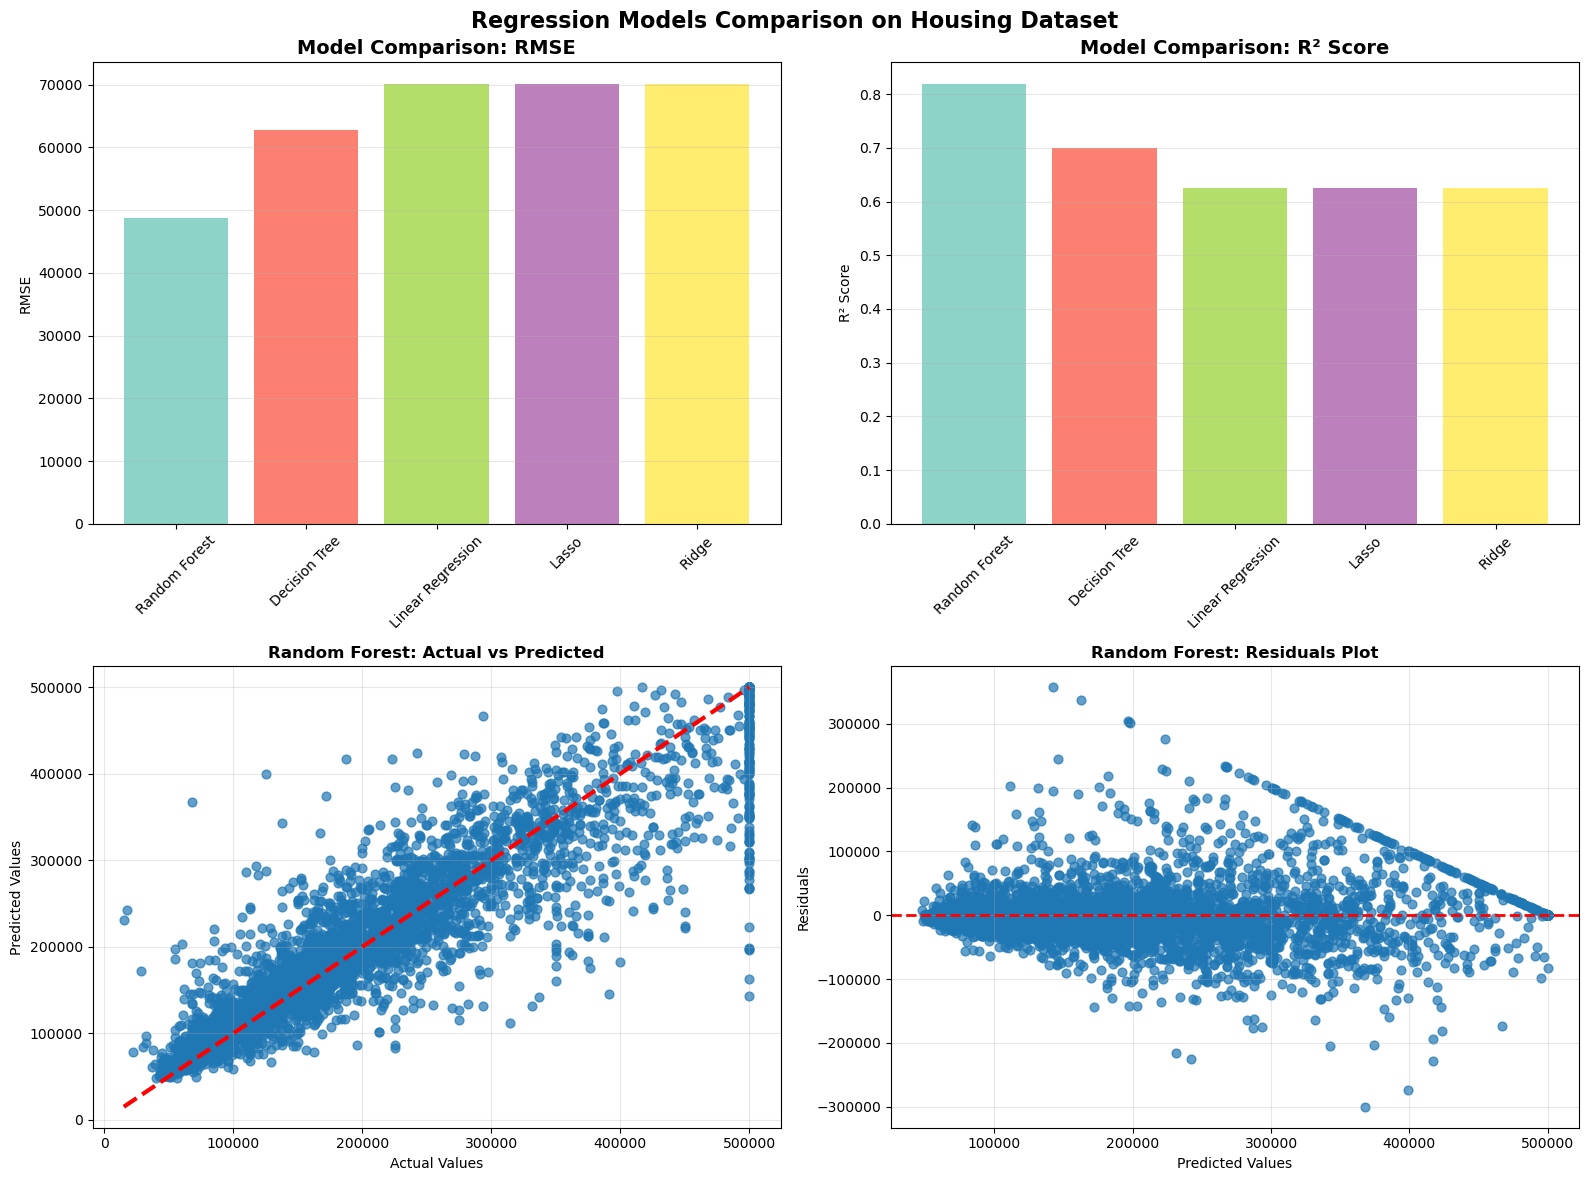


Best Model: Random Forest
   Test RMSE: 48810.873
   Test R²:   0.818


In [31]:
df = pd.read_csv('housing.csv')

print("Dataset shape:", df.shape)
print("Missing values per column:")
print(df.isnull().sum())

# Find numeric target
numeric_cols = df.select_dtypes(include=[np.number]).columns
target_col = numeric_cols[-1]
print(f"\nUsing '{target_col}' as target")

X = df.drop(target_col, axis=1)
y = df[target_col].astype(np.float64)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols_X = X.select_dtypes(include=[np.number]).columns.tolist()

# Preprocessing pipelines with imputation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols_X),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "Decision Tree": DecisionTreeRegressor(max_depth=8, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=150, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train_prep, y_train)
    y_pred = model.predict(X_test_prep)
    rmse = root_mean_squared_error(y_test, y_pred)  # FIXED: Use direct RMSE function
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "RMSE": rmse, "R2": r2})

results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\nResults:")
print(results_df.to_string(index=False))

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

axes[0,0].bar(results_df['Model'], results_df['RMSE'], color=colors)
axes[0,0].set_title('Model Comparison: RMSE', fontweight='bold', fontsize=14)
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylabel('RMSE')
axes[0,0].grid(axis='y', alpha=0.3)

axes[0,1].bar(results_df['Model'], results_df['R2'], color=colors)
axes[0,1].set_title('Model Comparison: R² Score', fontweight='bold', fontsize=14)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylabel('R² Score')
axes[0,1].grid(axis='y', alpha=0.3)

rf_preds = models["Random Forest"].predict(X_test_prep)
axes[1,0].scatter(y_test, rf_preds, alpha=0.7, s=40)
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
axes[1,0].set_xlabel('Actual Values')
axes[1,0].set_ylabel('Predicted Values')
axes[1,0].set_title('Random Forest: Actual vs Predicted', fontweight='bold')
axes[1,0].grid(alpha=0.3)

residuals_rf = y_test - rf_preds
axes[1,1].scatter(rf_preds, residuals_rf, alpha=0.7, s=40)
axes[1,1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1,1].set_xlabel('Predicted Values')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Random Forest: Residuals Plot', fontweight='bold')
axes[1,1].grid(alpha=0.3)

plt.suptitle('Regression Models Comparison on Housing Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nBest Model: {results_df.iloc[0]['Model']}")
print(f"   Test RMSE: {results_df.iloc[0]['RMSE']:.3f}")
print(f"   Test R²:   {results_df.iloc[0]['R2']:.3f}")